In [1]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper.mplstyle')
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b
from scipy.optimize import fsolve
import cmath

In [2]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [3]:
def make_sim(P, mass, ecc, pom):
    mu1, mu2, mu3 = mass
    P1, P2, P3 = P
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2,f=0.5)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3,f=0.8)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [4]:
def getT(sim):
    ps = sim.particles    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    Delta = (ec12 - ec23)/ec13
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    A = mu1*a/(mu1*a+m3*b)
    B = mu3*b/(mu1*a+m3*b)
    
    T = np.array([[A,-(A+B),B],[1,0,-1],[mu1,mu2,mu3]])
    
    print(f"delta={Delta}")
    return T

def StoE(sim,S,phi):
    T = getT(sim)
    S1, S2, S3 = S
    p1, p2, p3 = phi
    S_vec = np.array([[S1*cmath.exp(1j*p1)], [S2*cmath.exp(1j*p2)], [S3*cmath.exp(1j*p3)]])
    e_vec = np.linalg.inv(T) @ S_vec
    
    e1, e2, e3 = np.abs(e_vec[0][0]), np.abs(e_vec[1][0]), np.abs(e_vec[2][0])
    pom1, pom2, pom3 = cmath.phase(e_vec[0][0]), cmath.phase(e_vec[1][0]), cmath.phase(e_vec[2][0])
    
    return (e1, e2, e3), (pom1, pom2, pom3)

def EtoS(sim,ecc,pomega):
    e1, e2, e3 = ecc
    pom1, pom2, pom3 = pomega
    
    T = getT(sim)
    e_vec = np.array([[e1*cmath.exp(1j*pom1)], [e2*cmath.exp(1j*pom2)], [e3*cmath.exp(1j*pom3)]])
    S_vec = T @ e_vec
    
    S1, S2, S3 = np.abs(S_vec[0][0]), np.abs(S_vec[1][0]), np.abs(S_vec[2][0])
    phi1, phi2, phi3 = cmath.phase(S_vec[0][0]), cmath.phase(S_vec[1][0]), cmath.phase(S_vec[2][0])
    
    return (S1, S2, S3), (phi1, phi2, phi3)

In [19]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T

    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    Delta = (ec12 - ec23)/ec13
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    A = mu1*a/(mu1*a+m3*b)
    B = mu3*b/(mu1*a+m3*b)
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    e1,e2,e3,e12, e23, e13, eminus, ecom = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout),np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        
        e1x, e2x, e3x = [p.e*np.cos(p.pomega) for p in ps[1:]]
        e1y, e2y, e3y = [p.e*np.sin(p.pomega) for p in ps[1:]]
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
        
        e1[i] = np.sqrt(e1x**2+e1y**2)
        e2[i] = np.sqrt(e2x**2+e2y**2)
        e3[i] = np.sqrt(e3x**2+e3y**2)
        e12[i] = np.sqrt((e2x-e1x)**2+(e2y-e1y)**2)
        e23[i] = np.sqrt((e3x-e2x)**2+(e3y-e2y)**2)
        e13[i] = np.sqrt((e3x-e1x)**2+(e3y-e1y)**2)
        eminus[i] = np.sqrt((B*(e3x-e2x)-A*(e2x-e1x))**2 + (B*(e3y-e2y)-A*(e2y-e1y))**2)
        ecom[i] = np.sqrt((mu1*e1x+mu2*e2x+mu3*e3x)**2+(mu1*e1y+mu2*e2y+mu3*e3y)**2)
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    
    return times, e12, e23, eminus, e13, ecom, e1,e2,e3,S1,S2,S3

In [20]:
# P = 1, 1.31, 1.54
# mass = 3e-6, 3e-6, 3e-6
# ecc = 0,0,0
# pom = 0,0,0
# sim = make_sim(P, mass, ecc, pom)
# print(EtoS(sim,ecc,pom))
# times, e12, e23, eminus, e13, ecom, e1, e2, e3 = run(sim)

In [28]:
P = 1, 1.18, 1.46
mass = 3e-6, 1e-12, 3e-6
ecc = 0,0,0
pom = 0,0,0
sim = make_sim(P, mass, ecc, pom)

In [29]:
getT(sim)

delta=-0.12494921943950678


array([[ 9.99996931e-01, -1.51155757e+00,  5.11560644e-01],
       [ 1.00000000e+00,  0.00000000e+00, -1.00000000e+00],
       [ 4.99999917e-01,  1.66666639e-07,  4.99999917e-01]])

In [30]:
(P[1]/P[2])**(2/3)

0.8676663755592563

In [31]:
StoE(sim,(0.01,0.01,0.008),(-np.pi/4,np.pi/2.3,np.pi/6))

delta=-0.12494921943950678


((0.011927246225907647, 0.01057903339192327, 0.005978361051495483), (0.8417448928293388, 1.3245382526627802, -0.150342
8090768376))

In [32]:
ecc, pomega = StoE(sim,(0.01,0.01,0.008),(-np.pi/4,np.pi/2.3,np.pi/6))
sim = make_sim(P, mass, ecc, pomega)
times, e12, e23, eminus, e13, ecom, e1, e2, e3, S1, S2, S3 = run(sim)

delta=-0.12494921943950678
delta=-0.12494921943950933


(-0.215, 0.215)

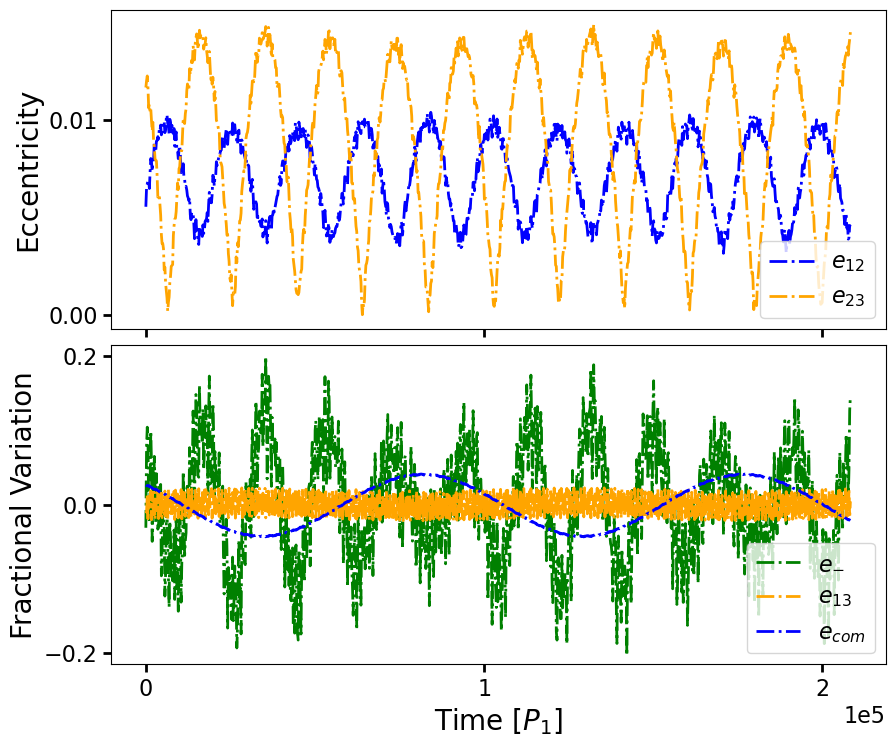

In [35]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8.5),sharex=True)
fig.subplots_adjust(hspace=0.05)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax1.plot(times, e12, color='blue', linestyle='-.',lw=2,label=r"$e_{12}$")
ax1.plot(times, e23, color='orange', linestyle='-.',lw=2,label=r"$e_{23}$")
ax1.legend(loc="lower right")

# ax2.plot(times, (S1-np.mean(S1))/np.mean(S1), color='green', linestyle='-.',lw=2, label=r"$e_{-}$")
# ax2.plot(times, (S2-np.mean(S2))/np.mean(S2), color='orange', linestyle='-.', lw=2,label=r"$e_{13}$")
# ax2.plot(times, (S3-np.mean(S3))/np.mean(S3), color='blue', linestyle='-.', lw=2,label=r"$e_{com}$")
ax2.plot(times, (eminus-np.mean(eminus))/np.mean(eminus), color='green', linestyle='-.',lw=2, label=r"$e_{-}$")
ax2.plot(times, (e13-np.mean(e13))/np.mean(e13), color='orange', linestyle='-.', lw=2,label=r"$e_{13}$")
ax2.plot(times, (ecom-np.mean(ecom))/np.mean(ecom), color='blue', linestyle='-.', lw=2,label=r"$e_{com}$")
ax2.legend(loc="lower right")

ax1.locator_params(axis='y', nbins=3)
ax2.locator_params(axis='y', nbins=4)
ax2.locator_params(axis='x', nbins=4)
ax1.set_ylabel("Eccentricity")
ax2.set_ylabel("Fractional Variation")
ax2.set_xlabel(r"Time [$P_1$]")
ax2.set_ylim([-0.215,0.215])

In [85]:
dpi = 300.4
fig.savefig('Nbody.pdf', transparent=True, dpi=dpi, bbox_inches='tight')